In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --------------------------
# 0) CONFIG (EDIT PATH)
# --------------------------
DATA_PATH = r"C:\Users\Vartotojas\Documents\AIA Project 2\asl_landmarks_final.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20

PARAM_GRID = {
    "svc__C":     [1, 3, 10, 30, 100],
    "svc__gamma": [0.001, 0.003, 0.01, 0.03, 0.1, "scale"]
}

possible_label_cols = ["label", "Label", "class", "Class", "sign", "Sign", "gesture", "Gesture", "letter", "Letter"]

# --------------------------
# 1) LOAD DATASET
# --------------------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)
print(df.head())


Loaded dataset: (2203, 64)
         x0        y0            z0        x1        y1        z1        x2  \
0  0.302490  0.495331 -4.277665e-07  0.401974  0.430925 -0.032561  0.477837   
1  0.765451  0.343823 -3.595415e-07  0.847147  0.297660 -0.020126  0.900564   
2  0.354618  0.851986 -5.631421e-07  0.456605  0.802520 -0.032938  0.531164   
3  0.508807  0.903747 -4.856587e-07  0.601312  0.872814 -0.048935  0.698089   
4  0.424728  0.795478 -5.605922e-07  0.571597  0.744283 -0.063864  0.700230   

         y2        z2        x3  ...       x18       y18       z18       x19  \
0  0.337875 -0.043061  0.478437  ...  0.213375  0.267955 -0.066850  0.231382   
1  0.220337 -0.024878  0.908948  ...  0.702640  0.151641 -0.048588  0.717729   
2  0.713107 -0.044213  0.533721  ...  0.292963  0.614532 -0.061759  0.306808   
3  0.763118 -0.064034  0.720130  ...  0.421785  0.662791 -0.088294  0.430163   
4  0.593906 -0.080447  0.721148  ...  0.309938  0.437413 -0.105951  0.333689   

        y19      

In [14]:

# --------------------------
# 2) DETECT LABEL COLUMN + FEATURE COLUMNS
# --------------------------
label_col = next((c for c in possible_label_cols if c in df.columns), None)
if label_col is None:
    raise ValueError(
        "Label column not found. Rename your label column to one of: "
        + ", ".join(possible_label_cols)
    )
print("Label column:", label_col)

feature_cols = [c for c in df.columns if c != label_col and pd.api.types.is_numeric_dtype(df[c])]
if len(feature_cols) < 63:
    raise ValueError(f"Expected at least 63 numeric features, found {len(feature_cols)}. Check your dataset columns.")
print("Numeric feature columns:", len(feature_cols))

X = df[feature_cols].to_numpy(dtype=np.float32)
y_raw = df[label_col].astype(str).to_numpy()

print("X shape:", X.shape)
print("y sample:", y_raw[:10])


Label column: label
Numeric feature columns: 63
X shape: (2203, 63)
y sample: ['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A']


In [15]:

# --------------------------
# 3) LABEL ENCODING
# --------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Classes:", list(le.classes_))
print("Num classes:", len(le.classes_))


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']
Num classes: 28


In [16]:

# --------------------------
# 4) TRAIN/TEST SPLIT (STRATIFIED)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1762, 63) Test: (441, 63)


## 5. Model 1: Support Vector Machine (RBF) with Grid Search

Support Vector Machine (SVM) classifier with a Radial Basis Function (RBF) kernel was used. To ensure robust performance and optimal hyperparameter selection, the model was trained using a scikit-learn Pipeline combined with GridSearchCV.

#### 5.1 Pipeline Construction

A pipeline was created to combine feature scaling and classification into a single workflow:

The pipeline consists of two stages:

- StandardScaler - all input features to have zero mean and unit variance. This step is critical for SVMs, as they are sensitive to the scale of input features.

- Support Vector Classifier (SVC) - An SVM with an RBF kernel was selected to handle non-linear decision boundaries common in hand landmark data.
The class_weight="balanced" option compensates for possible class imbalance by assigning higher importance to underrepresented classes.

Using a pipeline ensures that feature scaling is applied correctly during cross-validation and prevents data leakage.

In [17]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced"))
])


#### 5.2 Hyperparameter Optimization with Grid Search

To find the optimal SVM hyperparameters, a grid search with cross-validation was performed:

In [18]:

grid = GridSearchCV(
    pipe,
    param_grid=PARAM_GRID,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)


#### 5.3 Model Training and Selection

In [19]:

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


#### 5.4 Cross-Validation Results

In [20]:

print("\nBest params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)



Best params: {'svc__C': 100, 'svc__gamma': 0.003}
Best CV accuracy: 0.9580076616018541


#### 5.5 Test Set Evaluation

In [21]:

pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print("\nTest Accuracy:", acc)



Test Accuracy: 0.9659863945578231


#### 5.6 Classification Report

In [22]:

labels_all = np.arange(len(le.classes_))
print("\nClassification Report:\n")
print(classification_report(
    y_test, pred,
    labels=labels_all,
    target_names=le.classes_,
    digits=4,
    zero_division=0
))



Classification Report:

              precision    recall  f1-score   support

           A     0.8750    1.0000    0.9333        14
           B     1.0000    1.0000    1.0000        14
           C     1.0000    0.9231    0.9600        13
           D     0.9000    1.0000    0.9474        18
           E     0.9444    1.0000    0.9714        17
           F     1.0000    1.0000    1.0000        20
           G     1.0000    1.0000    1.0000        16
           H     1.0000    1.0000    1.0000        17
           I     1.0000    0.9286    0.9630        14
           J     0.9600    0.9231    0.9412        26
           K     1.0000    1.0000    1.0000        18
           L     1.0000    1.0000    1.0000        15
           M     1.0000    0.8182    0.9000        11
           N     0.8889    1.0000    0.9412         8
           O     1.0000    0.9375    0.9677        16
           P     0.8235    1.0000    0.9032        14
           Q     1.0000    0.7857    0.8800        14
  

#### 5.7 CONFUSION MATRIX + PER-CLASS RECALL

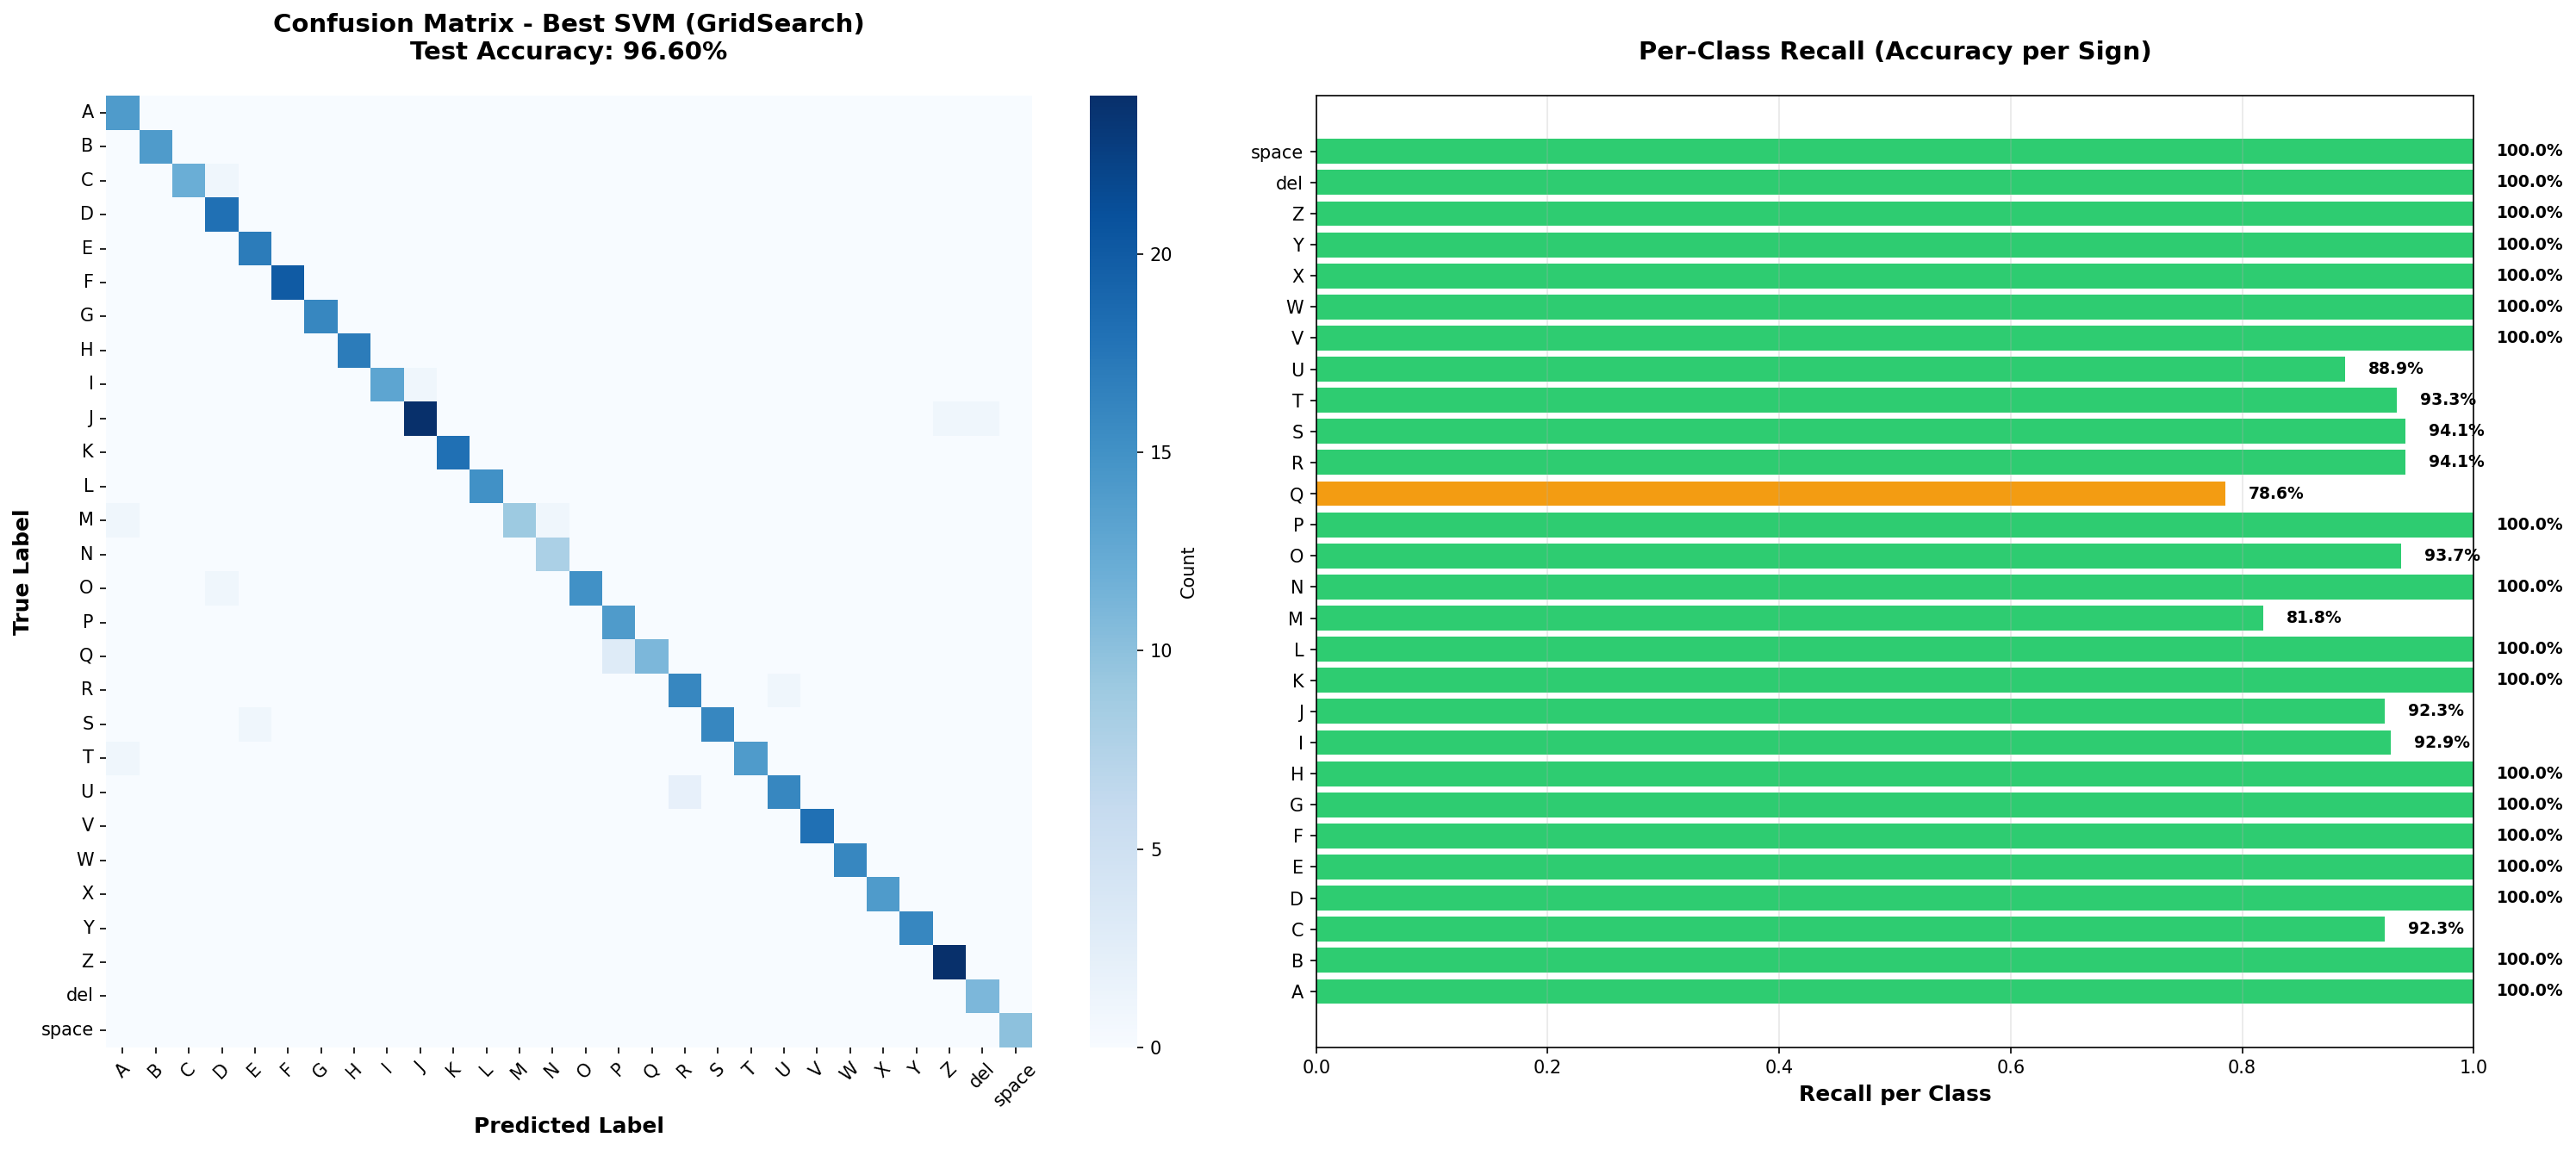

Saved: model1_confusion_matrix_best_svm.png


In [23]:
cm = confusion_matrix(y_test, pred, labels=labels_all)
recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(20, 9), dpi=150)

# Confusion matrix
ax1 = axes[0]
sns.heatmap(
    cm, cmap="Blues", annot=False,
    xticklabels=le.classes_, yticklabels=le.classes_,
    cbar_kws={"label": "Count"}, ax=ax1
)
ax1.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax1.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax1.set_title(f"Confusion Matrix - Best SVM (GridSearch)\nTest Accuracy: {acc*100:.2f}%",
              fontsize=14, fontweight="bold", pad=20)
ax1.tick_params(axis="x", rotation=45)

# Per-class recall
ax2 = axes[1]
colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.6 else '#e74c3c'
          for x in recall_per_class]
ax2.barh(le.classes_, recall_per_class, color=colors)
ax2.set_xlabel("Recall per Class", fontsize=12, fontweight="bold")
ax2.set_title("Per-Class Recall (Accuracy per Sign)", fontsize=14, fontweight="bold", pad=20)
ax2.set_xlim(0, 1)
ax2.grid(axis="x", alpha=0.3)

for i, val in enumerate(recall_per_class):
    ax2.text(val + 0.02, i, f"{val*100:.1f}%", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig("model1_confusion_matrix_best_svm.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: model1_confusion_matrix_best_svm.png")

#### 5.8 SAVE METRICS CSV 

In [ ]:

metrics_df = pd.DataFrame({
    "Class": le.classes_,
    "Recall": recall_per_class,
    "Total_Samples": cm.sum(axis=1),
    "Correct_Predictions": np.diag(cm)
})
metrics_df["Recall_Percent"] = metrics_df["Recall"] * 100

overall = pd.DataFrame([{
    "Class": "OVERALL",
    "Recall": acc,
    "Total_Samples": int(cm.sum()),
    "Correct_Predictions": int(np.diag(cm).sum()),
    "Recall_Percent": acc * 100
}])

metrics_df = pd.concat([metrics_df, overall], ignore_index=True)
metrics_df.to_csv("model1_best_svm_metrics.csv", index=False)
print("Saved: model1_best_svm_metrics.csv")

# SAVE MODEL + LABEL ENCODER
joblib.dump(best_model, "model1_best_svm_mediapipe_keypoints.joblib")
joblib.dump(le, "model1_label_encoder.joblib")
print("Saved model: model1_best_svm_mediapipe_keypoints.joblib")
print("Saved label encoder: model1_label_encoder.joblib")

Saved: model1_best_svm_metrics.csv
Saved model: model1_best_svm_mediapipe_keypoints.joblib
Saved label encoder: model1_label_encoder.joblib
